<a href="https://colab.research.google.com/github/lunathanael/Optimize/blob/nate/optimize_gbt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./.config/.last_update_check.json
./.config/active_config
./.config/gce
./.config/config_sentinel
./.config/.last_opt_in_prompt.yaml
./.config/default_configs.db
./.config/.last_survey_prompt.yaml
./.config/configurations/config_default
./.config/logs/2023.09.21/13.49.10.454054.log
./.config/logs/2023.09.21/13.49.01.549218.log
./.config/logs/2023.09.21/13.48.45.393225.log
./.config/logs/2023.09.21/13.48.20.358335.log
./.config/logs/2023.09.21/13.48.54.318162.log
./.config/logs/2023.09.21/13.49.11.211030.log
./sample_data/README.md
./sample_data/anscombe.json
./sample_data/mnist_train_small.csv
./sample_data/california_housing_test.csv
./sample_data/california_housing_train.csv
./sample_data/mnist_test.csv


In [ ]:
# lib import
import numpy as np
from numpy import inf
import pandas as pd
import tensorflow_decision_forests as tfdf

TRAINING = True

In [ ]:
def generate_features(df):
    features = ['seconds_in_bucket', 'imbalance_buy_sell_flag',
               'imbalance_size', 'matched_size', 'bid_size', 'ask_size',
                'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap',
                'imb_s1', 'imb_s2'
               ]

    df['imb_s1'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)')
    df['imb_s2'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')

    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']

    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            if i>j:
                df[f'{a}_{b}_imb'] = df.eval(f'({a}-{b})/({a}+{b})')
                features.append(f'{a}_{b}_imb')

    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            for k,c in enumerate(prices):
                if i>j and j>k:
                    max_ = df[[a,b,c]].max(axis=1)
                    min_ = df[[a,b,c]].min(axis=1)
                    mid_ = df[[a,b,c]].sum(axis=1)-min_-max_

                    df[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_)
                    features.append(f'{a}_{b}_{c}_imb2')

    return df[features]

In [ ]:
if TRAINING:
    # load dataset
    df_train = pd.read_csv('./train.csv')
    df_features = generate_features(df_train)

    # data is defaulty normalized
    X = np.float32(df_features.values)
    Y = np.float32(df_train['target'].values)

    X = X[np.isfinite(Y)]
    Y = Y[np.isfinite(Y)]

    index = np.arange(len(X)) #array for indexing

    max_value = np.finfo(X.dtype).max #max float value allowed by numpy, perhaps lower? to prevent NAN during fit
    min_value = np.finfo(X.dtype).min
#     X[X==inf] = max_value
#     X[~np.isfinite(X)] = min_value
    X[X==inf] = 3.40282e+14
    X[~np.isfinite(X)] = -3.40282e+14

In [ ]:
models = []

# test to train ratio
N_fold = 5

def train(tuned_model):
    if TRAINING:
          tuned_model.fit(X[index%N_fold!=0][0:40000, : ], Y[index%N_fold!=0][0:40000], verbose=2)

#         model = tfdf.keras.GradientBoostedTreesModel()
#         model.fit(X[index%N_fold!=i], Y[index%N_fold!=i],
#                     eval_set=[(X[index%N_fold==i], Y[index%N_fold==i])],
#                     verbose=10,
#                     early_stopping_rounds=100
#                     )

tuner = tfdf.tuner.RandomSearch(num_trials=100, use_predefined_hps=True)
tuned_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION, tuner=tuner, verbose=1)
train(tuned_model)
tuned_model.compile(metrics=["mae"])


Use /tmp/tmpgcwqak7x as temporary training directory
Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(32, 49), dtype=float32)
Label: Tensor("data_1:0", shape=(32,), dtype=float32)
Weights: None
Normalized tensor features:
 {'data:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(32,) dtype=float32>), 'data:0.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(32,) dtype=float32>), 'data:0.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(32,) dtype=float32>), 'data:0.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(32,) dtype=float32>), 'data:0.4': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_4:0' shape=(32,) dtype=float32>), 'data:0.5': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_5:0' 

[INFO 23-11-04 17:31:58.4746 UTC kernel.cc:773] Start Yggdrasil model training
[INFO 23-11-04 17:31:58.4746 UTC kernel.cc:774] Collect training examples
[INFO 23-11-04 17:31:58.4746 UTC kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-11-04 17:31:58.4763 UTC kernel.cc:393] Number of batches: 1250
[INFO 23-11-04 17:31:58.4764 UTC kernel.cc:394] Number of examples: 40000
[INFO 23-11-04 17:31:58.4874 UTC kernel.cc:794] Training dataset:
Number of records: 40000
Number of columns: 50

Number of columns by type:
	NUMERICAL: 50 (100%)

Columns:

NUMERICAL: 50 (100%)
	0: "__LABEL" NUMERICAL mean:-0.257429 min:-130.83 max:98.8495 sd:8.6433
	1: "data:0.0" NUMERICAL mean:259.308 min:0 max:540 sd:155.18
	2: "data:0.1" NUMERICA

Model trained in 15:11:36.096382
Compiling model...
Model compiled.


In [ ]:
tuned_test_accuracy = tuned_model.evaluate(X[index%N_fold==0][0:20000, : ], Y[index%N_fold==0][0:20000], return_dict=True, verbose=0)["mae"]
print(tuned_test_accuracy)

5.213750839233398


In [ ]:
tuning_logs = tuned_model.make_inspector().tuning_logs()
tuning_logs.head()

,score,evaluation_time,best,split_axis,sparse_oblique_projection_density_factor,sparse_oblique_normalization,sparse_oblique_weights,categorical_algorithm,growing_strategy,max_depth,sampling_method,subsample,shrinkage,min_examples,num_candidate_attributes_ratio,max_num_nodes
0,-8.218175,2467.965598,False,SPARSE_OBLIQUE,4.0,STANDARD_DEVIATION,CONTINUOUS,CART,LOCAL,3.0,RANDOM,0.8,0.05,7,1.0,NaN
1,-8.143211,3189.592446,False,SPARSE_OBLIQUE,5.0,MIN_MAX,BINARY,CART,BEST_FIRST_GLOBAL,NaN,RANDOM,0.6,0.10,20,0.5,16.0
2,-7.892285,4346.781670,False,SPARSE_OBLIQUE,5.0,NONE,CONTINUOUS,CART,BEST_FIRST_GLOBAL,NaN,RANDOM,0.6,0.05,10,0.2,64.0
3,-7.911223,4396.937751,False,SPARSE_OBLIQUE,1.0,NONE,CONTINUOUS,RANDOM,BEST_FIRST_GLOBAL,NaN,RANDOM,0.6,0.10,10,0.9,256.0
4,-7.945287,4816.981907,False,SPARSE_OBLIQUE,2.0,MIN_MAX,BINARY,RANDOM,BEST_FIRST_GLOBAL,NaN,RANDOM,0.6,0.05,7,0.9,512.0


In [ ]:
tuning_logs = tuned_model.make_inspector().tuning_logs()
tuning_logs[tuning_logs.best].iloc[0]

score                                          -7.700172
evaluation_time                              27488.98287
best                                                True
split_axis                                  AXIS_ALIGNED
sparse_oblique_projection_density_factor             NaN
sparse_oblique_normalization                         NaN
sparse_oblique_weights                               NaN
categorical_algorithm                               CART
growing_strategy                                   LOCAL
max_depth                                            8.0
sampling_method                                   RANDOM
subsample                                            0.9
shrinkage                                            0.1
min_examples                                          10
num_candidate_attributes_ratio                       0.9
max_num_nodes                                        NaN
Name: 46, dtype: object

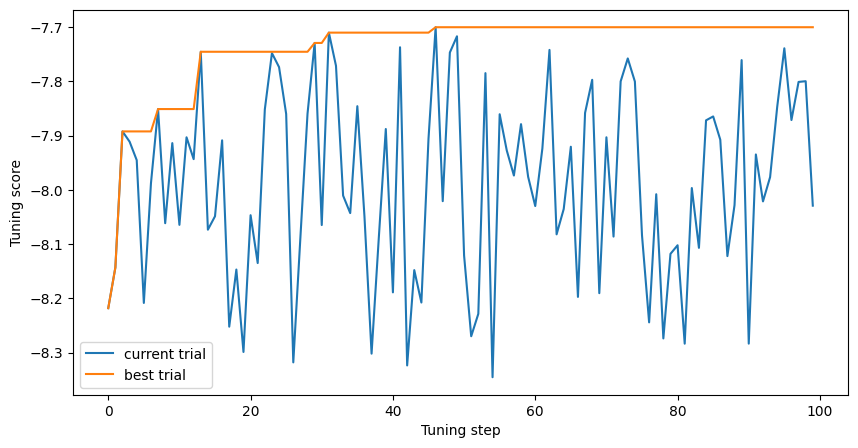

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model=tuned_model, tree_idx=0, max_depth=8)

In [ ]:
'''
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()
'''

In [ ]:
'''
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    if counter == 0:
        print(test.head(3))
        print(revealed_targets.head(3))
        print(sample_prediction.head(3))
    sample_prediction['target'] = model.predict(test)
    env.predict(sample_prediction)
    counter += 1
'''